In [43]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [44]:
import os
import pandas as pd
import numpy as np
from PIL import Image
from collections import Counter
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import shutil
from sklearn.metrics import confusion_matrix
import keras
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
import seaborn as sns
from sklearn.metrics import recall_score, f1_score, precision_score

Loading dataset ISIC 2019

In [45]:
def load_data(image_folder, ground_truth_file):
    #check if the image folder exists
    if not os.path.exists(image_folder):
        raise FileNotFoundError(f"The folder '{image_folder}' does not exis.")

    #check if the csv file exists
    if not os.path.exists(ground_truth_file):
        raise FileNotFoundError(f"The file '{ground_truth_file}'  does not exist.")

    #read the ground truth data from csv
    df_ground_truth = pd.read_csv(ground_truth_file)

    #add path and category columns
    df_ground_truth['path'] = df_ground_truth.apply(lambda row : os.path.join(image_folder, row['image']+'.jpg'), axis=1)
    df_ground_truth['category'] = np.argmax(np.array(df_ground_truth.iloc[:,1:10]), axis=1)

    return df_ground_truth

In [46]:
image_folder = '/content/drive/MyDrive/ISIC2019/ISIC_2019_Training_Input/ISIC'
removed_hair_image = '/content/drive/MyDrive/ISIC2019/removed_hair'
ground_truth_file = '/content/drive/MyDrive/ISIC2019/ISIC_2019_Training_GroundTruth.csv'
df = load_data(image_folder, ground_truth_file)
df.head()

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK,path,category
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,/content/drive/MyDrive/ISIC2019/ISIC_2019_Trai...,1
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,/content/drive/MyDrive/ISIC2019/ISIC_2019_Trai...,1
2,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,/content/drive/MyDrive/ISIC2019/ISIC_2019_Trai...,0
3,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,/content/drive/MyDrive/ISIC2019/ISIC_2019_Trai...,1
4,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,/content/drive/MyDrive/ISIC2019/ISIC_2019_Trai...,0


In [47]:
#category names
known_category_names = list(df.columns.values[1:9])
unknown_category_name = df.columns.values[9]
print("Known category name:", known_category_names,"\n Unknown category name:", unknown_category_name)

Known category name: ['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC'] 
 Unknown category name: UNK


Statistics about the dataset

Original training data has 25331 samples:
'MEL':	4522	(17.85%)
'NV':	12875	(50.83%)
'BCC':	3323	(13.12%)
'AK':	867	(3.42%)
'BKL':	2624	(10.36%)
'DF':	239	(0.94%)
'VASC':	253	(1.00%)
'SCC':	628	(2.48%)
'UNK':	0	(0.00%)
 


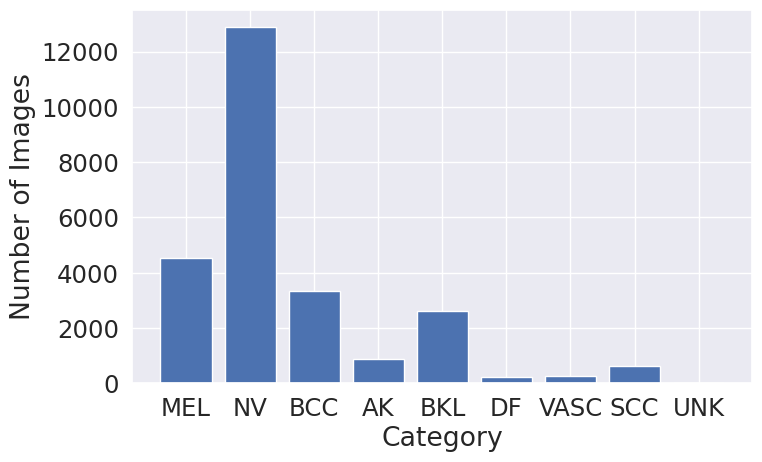

In [48]:
count_per_category = Counter(df['category'])
total_sample_count = sum(count_per_category.values())
all_category_names = known_category_names + [unknown_category_name]
print("Original training data has {} samples:".format(total_sample_count))
for i, c in enumerate(all_category_names):
    print("'%s':\t%d\t(%.2f%%)" % (c, count_per_category[i], count_per_category[i]*100/total_sample_count))

print(' ')
fig, ax = plt.subplots(figsize=(8, 5))
ax.set(xlabel='Category', ylabel='Number of Images')
plt.bar(all_category_names, [count_per_category[i] for i in range(9)])
fig.tight_layout()
plt.show()

Balance data

In [49]:
def balance_data(df_ground_truth, n_samples, random_state):
    df_balanced_list = []

    for category in df_ground_truth['category'].unique():
        df_category = df_ground_truth[df_ground_truth['category'] == category]
        df_balanced = resample(df_category, replace=True, n_samples=n_samples, random_state=random_state)
        df_balanced_list.append(df_balanced)

    df_balanced = pd.concat(df_balanced_list)
    return df_balanced

In [50]:
df_ground_truth_balanced = balance_data(df, n_samples=1000, random_state=42)

Use the path to read images

In [52]:
df_ground_truth_balanced['image'] = df_ground_truth_balanced['path'].map(lambda x: np.asarray(Image.open(x).resize((64,64))))

 Split the data into training and testing sets

In [53]:
x_isic = np.asarray(df_ground_truth_balanced['image'].tolist()) #convert dataframe column of images into numpy array
x_isic = x_isic/255. #scale values to 0-1
y_isic = to_categorical(df_ground_truth_balanced['category'], num_classes=8) #convert to categorical - multiclass classification problem
x_train, x_test, y_train, y_test = train_test_split(x_isic, y_isic, test_size=0.2, random_state=42)

Define the model

In [54]:
model = Sequential()
model.add(Conv2D(512, (3, 3), activation="relu", input_shape=(64, 64, 3)))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(8, activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 62, 62, 512)       14336     
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 31, 31, 512)       0         
 ng2D)                                                           
                                                                 
 dropout_20 (Dropout)        (None, 31, 31, 512)       0         
                                                                 
 conv2d_21 (Conv2D)          (None, 29, 29, 256)       1179904   
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 14, 14, 256)       0         
 ng2D)                                                           
                                                                 
 dropout_21 (Dropout)        (None, 14, 14, 256)      

In [55]:
history = model.fit(
    x_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(x_test, y_test),
    verbose=2)

score = model.evaluate(x_test, y_test)
print('Test accuracy:', score[1])

Epoch 1/50
200/200 - 12s - loss: 2.0484 - accuracy: 0.1636 - val_loss: 1.9804 - val_accuracy: 0.2212 - 12s/epoch - 61ms/step
Epoch 2/50
200/200 - 10s - loss: 1.8969 - accuracy: 0.2578 - val_loss: 1.7731 - val_accuracy: 0.3187 - 10s/epoch - 49ms/step
Epoch 3/50
200/200 - 10s - loss: 1.7811 - accuracy: 0.3100 - val_loss: 1.7098 - val_accuracy: 0.3269 - 10s/epoch - 49ms/step
Epoch 4/50
200/200 - 10s - loss: 1.7292 - accuracy: 0.3252 - val_loss: 1.6268 - val_accuracy: 0.3744 - 10s/epoch - 49ms/step
Epoch 5/50
200/200 - 10s - loss: 1.6599 - accuracy: 0.3530 - val_loss: 1.5660 - val_accuracy: 0.3913 - 10s/epoch - 49ms/step
Epoch 6/50
200/200 - 10s - loss: 1.6162 - accuracy: 0.3720 - val_loss: 1.5583 - val_accuracy: 0.3913 - 10s/epoch - 49ms/step
Epoch 7/50
200/200 - 10s - loss: 1.5838 - accuracy: 0.3881 - val_loss: 1.4954 - val_accuracy: 0.4338 - 10s/epoch - 49ms/step
Epoch 8/50
200/200 - 10s - loss: 1.5523 - accuracy: 0.3933 - val_loss: 1.4853 - val_accuracy: 0.4306 - 10s/epoch - 49ms/step


In [57]:
model.save(f'/content/drive/MyDrive/modelisic.keras')

Ploting the training and test accuracy and loss at each epoch

<ipython-input-58-8cfc67c26524>:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


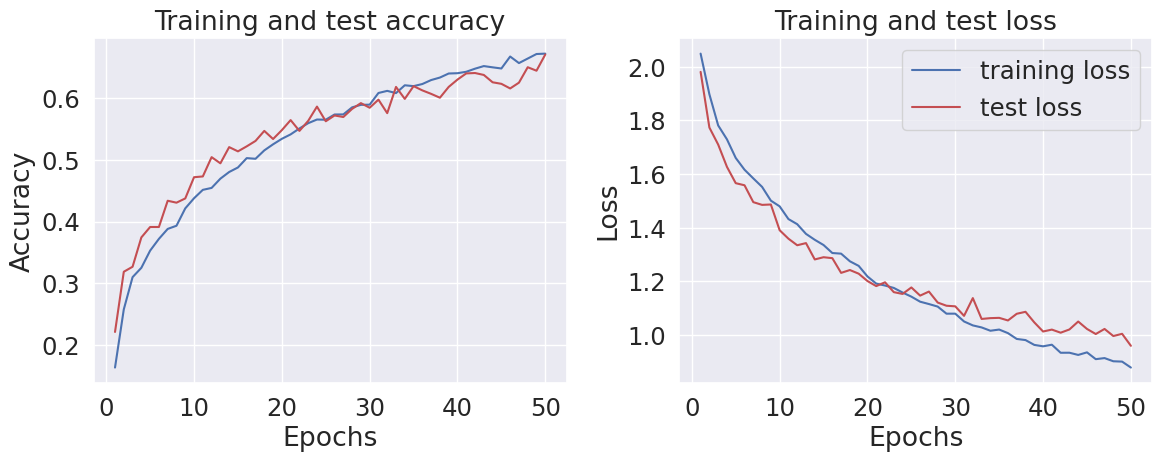

In [58]:
epochs = range(1, 51)
plt.subplots(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['accuracy'], label='training acc')
plt.plot(epochs,  history.history['val_accuracy'], 'r',  label='test acc')
plt.title('Training and test accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['loss'], label='training loss')
plt.plot(epochs, history.history['val_loss'], 'r', label='test loss')
plt.title('Training and test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

Prediction on test data

In [59]:
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis = 1)
y_true = np.argmax(y_test, axis = 1)

50/50 [==============================] - 1s 12ms/step


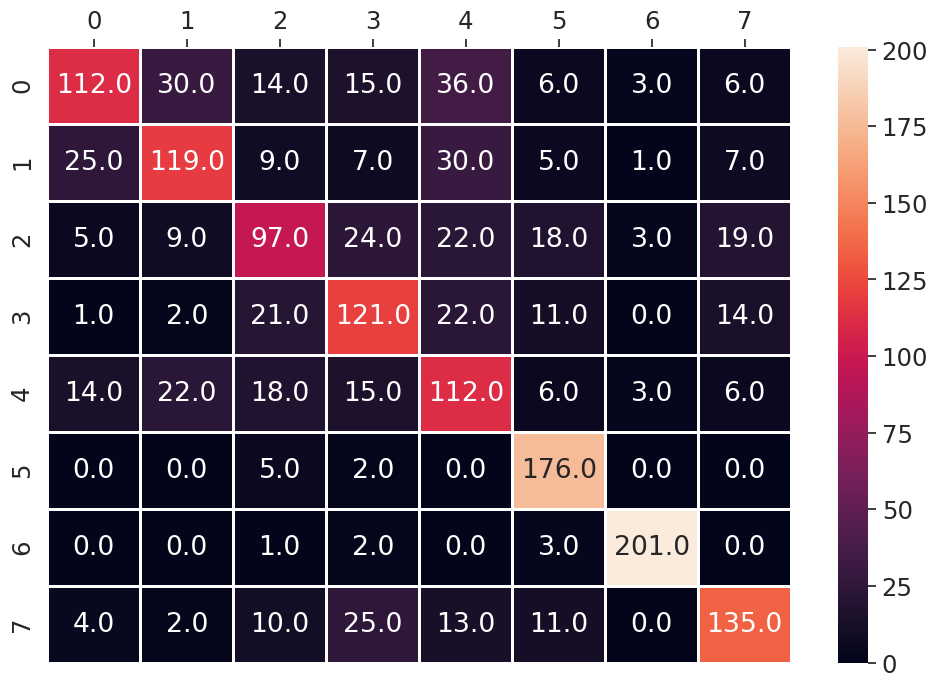

In [60]:
cm = confusion_matrix(y_true, y_pred_classes)

fig, ax = plt.subplots(figsize=(12,8))
sns.set(font_scale=1.6)
sns.heatmap(cm, annot=True, fmt=".1f", linewidths=.8, ax=ax)
ax.set(xlabel="", ylabel="")
ax.xaxis.tick_top()

In [61]:
results = pd.DataFrame({'Precision': precision_score(y_true, y_pred_classes, average=None),
                        'Recall': recall_score(y_true, y_pred_classes, average=None),
                        'F1_score': f1_score(y_true, y_pred_classes, average=None)})

results

,Precision,Recall,F1_score
0,0.695652,0.504505,0.584856
1,0.646739,0.586207,0.614987
2,0.554286,0.492386,0.521505
3,0.573460,0.630208,0.600496
4,0.476596,0.571429,0.519722
5,0.745763,0.961749,0.840095
6,0.952607,0.971014,0.961722
7,0.721925,0.675000,0.697674
